In [1]:
from fastai.vision import *
import os

## Loading dataset

In [2]:
path = Path('dataset')
path.ls()

[PosixPath('dataset/models'),
 PosixPath('dataset/test.csv'),
 PosixPath('dataset/Train Images'),
 PosixPath('dataset/export.pkl'),
 PosixPath('dataset/train.csv'),
 PosixPath('dataset/Test Images')]

In [3]:
# os.getcwd()
# os.listdir()
path

PosixPath('dataset')

In [4]:
df = pd.read_csv(path/'train.csv')
df.head()

,Image,Class
0,image7042.jpg,Food
1,image3327.jpg,misc
2,image10335.jpg,Attire
3,image8019.jpg,Food
4,image2128.jpg,Attire


In [5]:
np.random.seed(7) # fixing the split into train & valid

src = (ImageList.from_csv(path, 'train.csv', folder='Train Images')
       .split_by_rand_pct(0.2) # 20% validation data
       .label_from_df()
    )


In [6]:
data = (src.transform(get_transforms(), size=(60,80))
       .databunch()
       .normalize(imagenet_stats))

In [7]:
len(data.train_ds), len(data.valid_ds), data.classes, data.valid_ds[0]

(4787,
 1196,
 ['Attire', 'Decorationandsignage', 'Food', 'misc'],
 (Image (3, 60, 80), Category Attire))

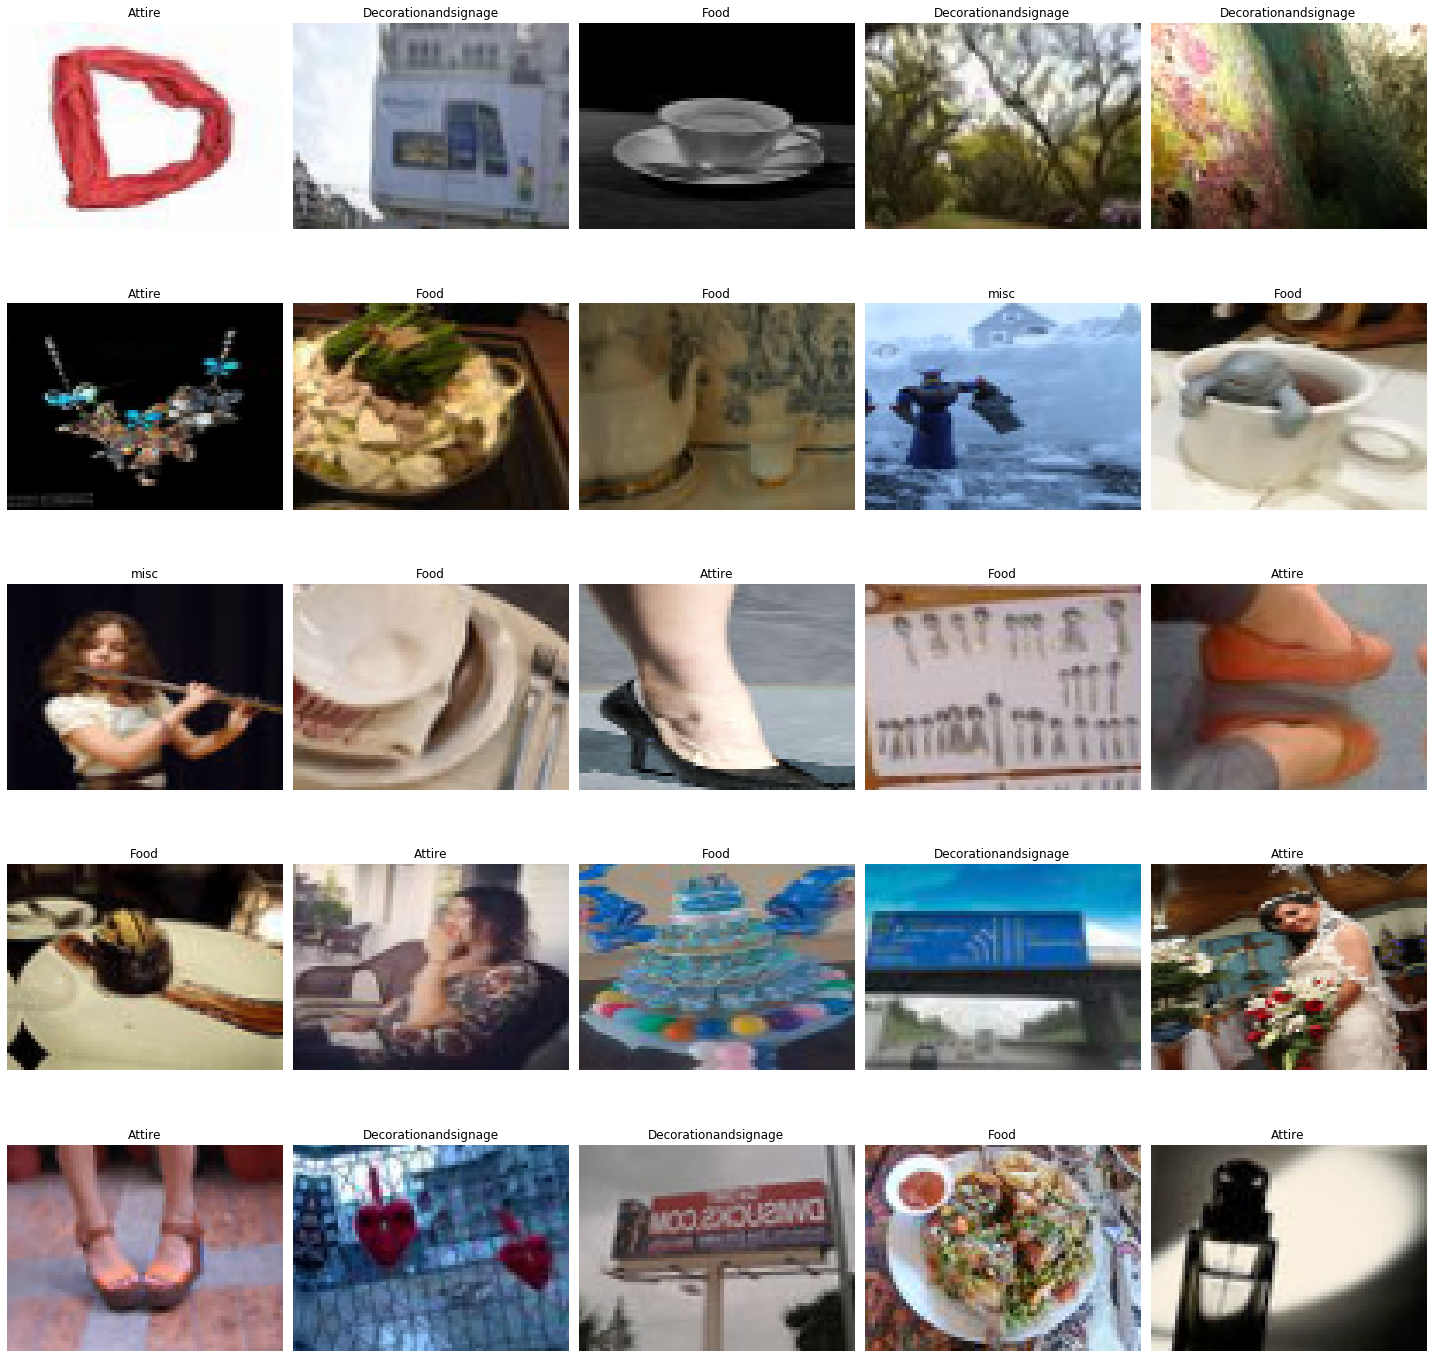

In [8]:
data.show_batch()

## Learner

In [9]:
f_score = partial(fbeta, beta=1.)

# metrics = [error_rate, f_score]  # performance matrices

In [9]:
learn =  cnn_learner(data, models.resnet50, metrics=accuracy)

In [10]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [11]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


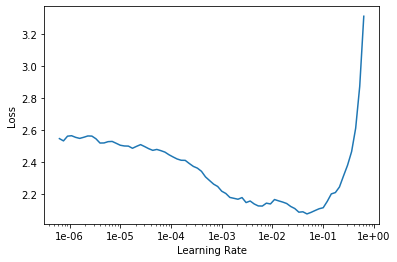

In [12]:
learn.recorder.plot()

In [13]:
lr = 1e-3/2

In [ ]:
learn.fit_one_cycle(12, slice(lr))

epoch,train_loss,valid_loss,accuracy,time


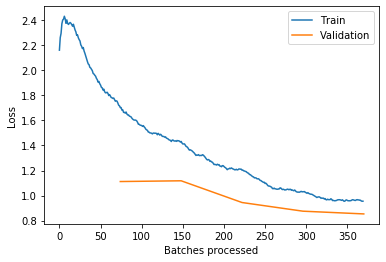

In [21]:
learn.recorder.plot_losses()

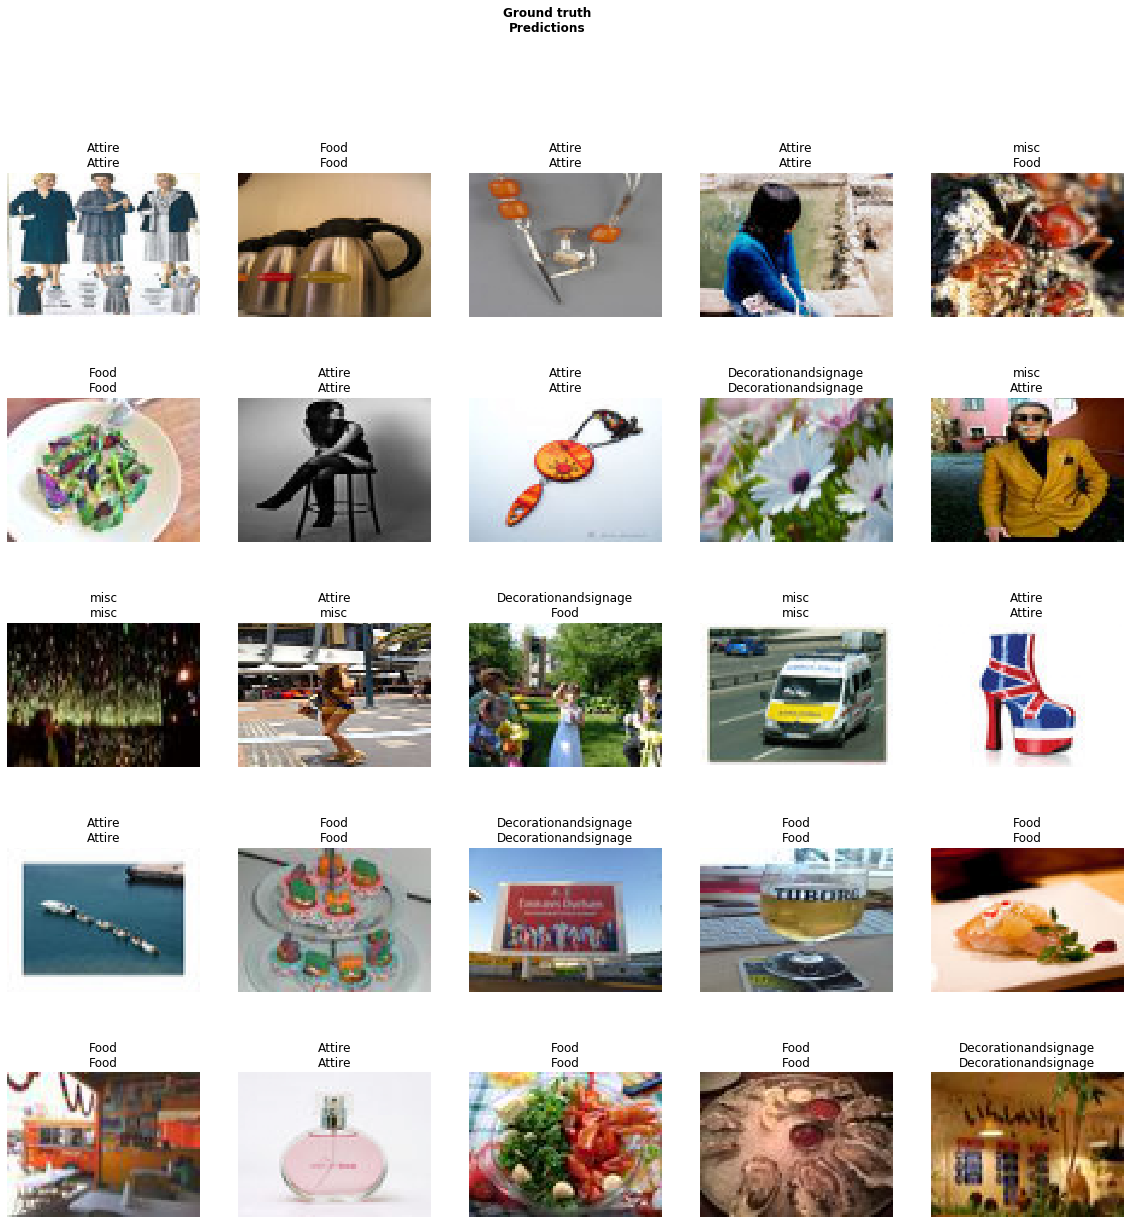

In [22]:
learn.show_results()

In [23]:
learn.save('stage-1-rn50')

In [25]:
learn.export()

In [27]:
os.listdir('dataset')

['models',
 'test.csv',
 'Train Images',
 'export.pkl',
 'train.csv',
 'Test Images']

## Results interpretation


In [28]:
interp = ClassificationInterpretation.from_learner(learn)

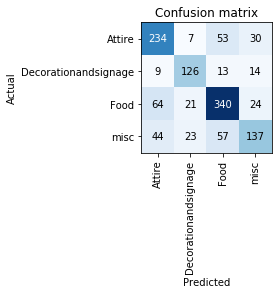

In [29]:
interp.plot_confusion_matrix()

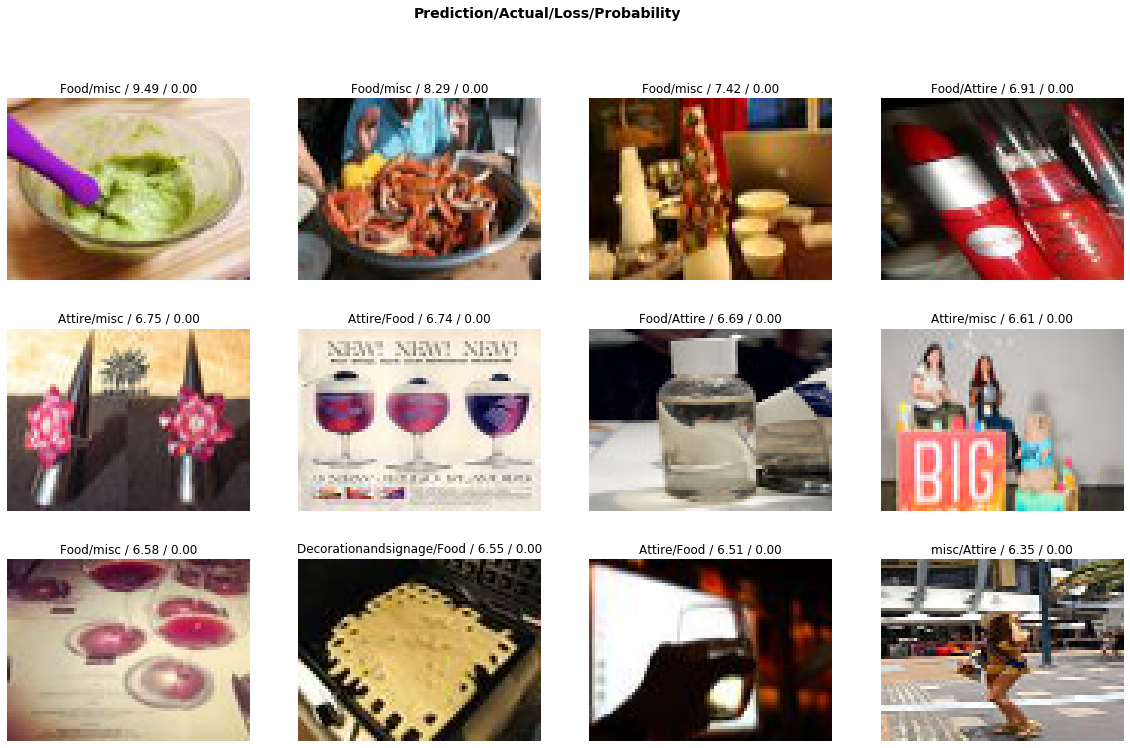

In [30]:
interp.plot_top_losses(12, figsize=(20,12))

In [31]:
interp.most_confused(12)

[('Food', 'Attire', 64),
 ('misc', 'Food', 57),
 ('Attire', 'Food', 53),
 ('misc', 'Attire', 44),
 ('Attire', 'misc', 30),
 ('Food', 'misc', 24),
 ('misc', 'Decorationandsignage', 23),
 ('Food', 'Decorationandsignage', 21),
 ('Decorationandsignage', 'misc', 14),
 ('Decorationandsignage', 'Food', 13)]

## Inference (for submission)

In [54]:
test_ds = ImageList.from_csv(path, 'test.csv', folder="Test Images")

In [55]:
# creating new learner to add test data
learn = load_learner(path, test=test_ds)

In [56]:
# prediction on testset
pred, y = learn.get_preds(ds_type=DatasetType.Test)

In [57]:
pred.shape

torch.Size([3219, 4])

In [58]:
pred[:3]

tensor([[0.4060, 0.2078, 0.3159, 0.0703],
        [0.2769, 0.0136, 0.6680, 0.0414],
        [0.6330, 0.0661, 0.2250, 0.0760]])

In [59]:
# extracting labels
labelled_pred = [ learn.data.classes[np.argmax(p)] for p in pred]

In [60]:
labelled_pred[:3]

['Attire', 'Food', 'Attire']

In [66]:
# filenames
fnames = [f.split('/')[-1] for f in learn.data.test_ds.items]

In [67]:
fnames[:3]

['image6245.jpg', 'image10409.jpg', 'image8692.jpg']

In [68]:
# reading test.csv order #to verify order
df = pd.read_csv(path/'test.csv')
df.head()

,Image
0,image6245.jpg
1,image10409.jpg
2,image8692.jpg
3,image10517.jpg
4,image2580.jpg


In [69]:
df = pd.DataFrame({'Image':fnames, "Class":labelled_pred}, columns=["Image", "Class"])

In [70]:
df.to_csv('submission.csv', index=False)

In [71]:
df = pd.read_csv('submission.csv')
df.head()

,Image,Class
0,image6245.jpg,Attire
1,image10409.jpg,Food
2,image8692.jpg,Attire
3,image10517.jpg,Food
4,image2580.jpg,Food
